Part of what is in here was taken from [here](https://www.kaggle.com/tarunpaparaju/plant-pathology-2020-eda-models) and other notebooks from this competition.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import pandas as pd
import glob
import cv2

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import (Dense, Dropout, Conv2D, MaxPool2D, Flatten, 
                          BatchNormalization, MaxPooling2D, GlobalAveragePooling2D)
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers as L

# visualization
import seaborn as sns
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
sns.set_context("talk")
sns.set_palette('husl')
sns.set()

from keras.preprocessing.image import ImageDataGenerator

path = '/kaggle/input/plant-pathology-2020-fgvc7/'
image_size = 300

import tensorflow as tf

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Using TensorFlow backend.


In [2]:
test = pd.read_csv(path + 'test.csv')
train = pd.read_csv(path + 'train.csv')
train['image_id']=train['image_id']+'.jpg'  # this is used in the image data generator below
test['image_id']=test['image_id']+'.jpg'

train.shape, test.shape

((1821, 5), (1821, 1))

In [ ]:
image = cv2.imread(path + 'images/Train_0.jpg')
# summarize shape of the pixel array
print(image.dtype)
print(image.shape)
plt.imshow(image)
plt.show()

In [ ]:
'''train_files = glob.glob(path + 'images/Train*')
train_batch = [cv2.resize(cv2.imread(tr_file),(image_size, image_size)) for tr_file in train_files]
train_batch = np.array(train_batch)'''

In [ ]:
'''test_files = glob.glob(path + 'images/Test*')
test_batch = [cv2.resize(cv2.imread(ts_file),(image_size, image_size)) for ts_file in test_files]
test_batch = np.array(test_batch)'''

In [ ]:
train, val = train_test_split(train, test_size = 0.3)

In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rotation_range=45,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=.1,
                                fill_mode='nearest',
                                shear_range=0.1,
                                rescale=1/255,
                                brightness_range=[0.5, 1.5])

# prepare an iterators to scale images
train_gen = datagen.flow_from_dataframe(train,
                                        directory=path+'images/',
                                        target_size=(image_size, image_size),
                                        x_col="image_id",
                                        y_col=['healthy','multiple_diseases','rust','scab'],
                                        class_mode='raw',
                                        shuffle=False,
                                        subset='training',
                                        batch_size=50)

val_gen = datagen.flow_from_dataframe(val,
                                        directory=path+'images/',
                                        target_size=(image_size,image_size),
                                        x_col="image_id",
                                        y_col=['healthy','multiple_diseases','rust','scab'],
                                        class_mode='raw',
                                        shuffle=False,
                                        batch_size=50)

test_gen = datagen.flow_from_dataframe(test,
                                        directory=path+'images/',
                                        target_size=(image_size,image_size),
                                        x_col="image_id",
                                        y_col=None,
                                        class_mode=None,
                                        shuffle=False,
                                        batch_size=50)

In [ ]:
# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    input_shape = (image_size, image_size, 3)  # 3 for RGB images and 1 for gray scale images

    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),  # size of the filter to use
                     strides=(1, 1),  # steps the filter is moved
                     padding='same',
                     activation='relu', 
                     kernel_regularizer=l2(0.001),
                     input_shape=input_shape)) 
    model.add(MaxPool2D(pool_size=(3, 3),  strides=(1, 1)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.001),))
    model.add(MaxPool2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Flatten())  # so the data can proceed to the fully-connected layer
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(4, activation='softmax'))
    
    model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [ ]:
train_step = train_gen.n//train_gen.batch_size
val_step = val_gen.n//val_gen.batch_size
history1 = model.fit_generator(generator=train_gen,
                                steps_per_epoch=train_step,
                                validation_data=val_gen,
                                validation_steps=val_step,
                                epochs=20,
                                callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
                             )

In [ ]:
history = history1

# set up figure
f = plt.figure(figsize=(12,5))
f.add_subplot(1,2, 1)

# plot accuracy as a function of epoch
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

# plot loss as a function of epoch
f.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show(block=True)

In [ ]:
SUB_PATH = "../input/plant-pathology-2020-fgvc7/sample_submission.csv"

sub = pd.read_csv(SUB_PATH)
predictions = model.predict(test_gen, verbose=1)
sub.loc[:, 'healthy':] = predictions
sub.to_csv('submission1.csv', index=False)
sub.head()

___

In [3]:
test = pd.read_csv(path + 'test.csv')
train = pd.read_csv(path + 'train.csv')

train_paths = np.array(glob.glob(path + 'images/Train*'))
test_paths = np.array(glob.glob(path + 'images/Test*'))
train_labels = np.float32(train.loc[:, 'healthy':'scab'].values.copy())

train_paths, valid_paths, train_labels, valid_labels =\
train_test_split(train_paths, train_labels, test_size=0.15, random_state=2020)

In [4]:
from kaggle_datasets import KaggleDatasets

GCS_DS_PATH = KaggleDatasets().get_gcs_path()

def format_path(st):
    return GCS_DS_PATH + '/images/' + st + '.jpg'

test = pd.read_csv(path + 'test.csv')
train = pd.read_csv(path + 'train.csv')

train_paths = train.image_id.apply(format_path).values
test_paths = test.image_id.apply(format_path).values
train_labels = np.float32(train.loc[:, 'healthy':'scab'].values.copy())

train_paths, valid_paths, train_labels, valid_labels =\
train_test_split(train_paths, train_labels, test_size=0.15, random_state=2020)

In [5]:
def decode_image(filename, label=None, image_size=(512, 512)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [6]:
BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

In [7]:
def build_lrfn(lr_start=0.00001, lr_max=0.00005, 
               lr_min=0.00001, lr_rampup_epochs=5, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * tpu_strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

In [8]:
lrfn = build_lrfn()
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

In [9]:
with tpu_strategy.scope():
    model = tf.keras.Sequential([DenseNet121(input_shape=(512, 512, 3),
                                             weights='imagenet',
                                             include_top=False),
                                 L.GlobalAveragePooling2D(),
                                 L.Dense(train_labels.shape[1],
                                         activation='softmax')])
        
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['categorical_accuracy'])

29089792/29084464 [==============================] - 0s 0us/step


In [10]:
history2 = model.fit(train_dataset,
                    epochs=10,
                    callbacks=[lr_schedule],
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset)

Train for 48 steps, validate for 9 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/10
48/48 [==============================] - 205s 4s/step - loss: 1.6009 - categorical_accuracy: 0.3008 - val_loss: 1.6606 - val_categorical_accuracy: 0.2336

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/10
48/48 [==============================] - 25s 529ms/step - loss: 0.6648 - categorical_accuracy: 0.7415 - val_loss: 0.5892 - val_categorical_accuracy: 0.8066

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/10
48/48 [==============================] - 30s 619ms/step - loss: 0.4341 - categorical_accuracy: 0.8561 - val_loss: 0.3885 - val_categorical_accuracy: 0.8686

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/10
48/48 [==============================] - 30s 619ms/step - loss: 0.3491 - categorical_accuracy: 0.8822 - val_loss: 0.4029 - val_categorical_accuracy: 0.8504

Epoch 00

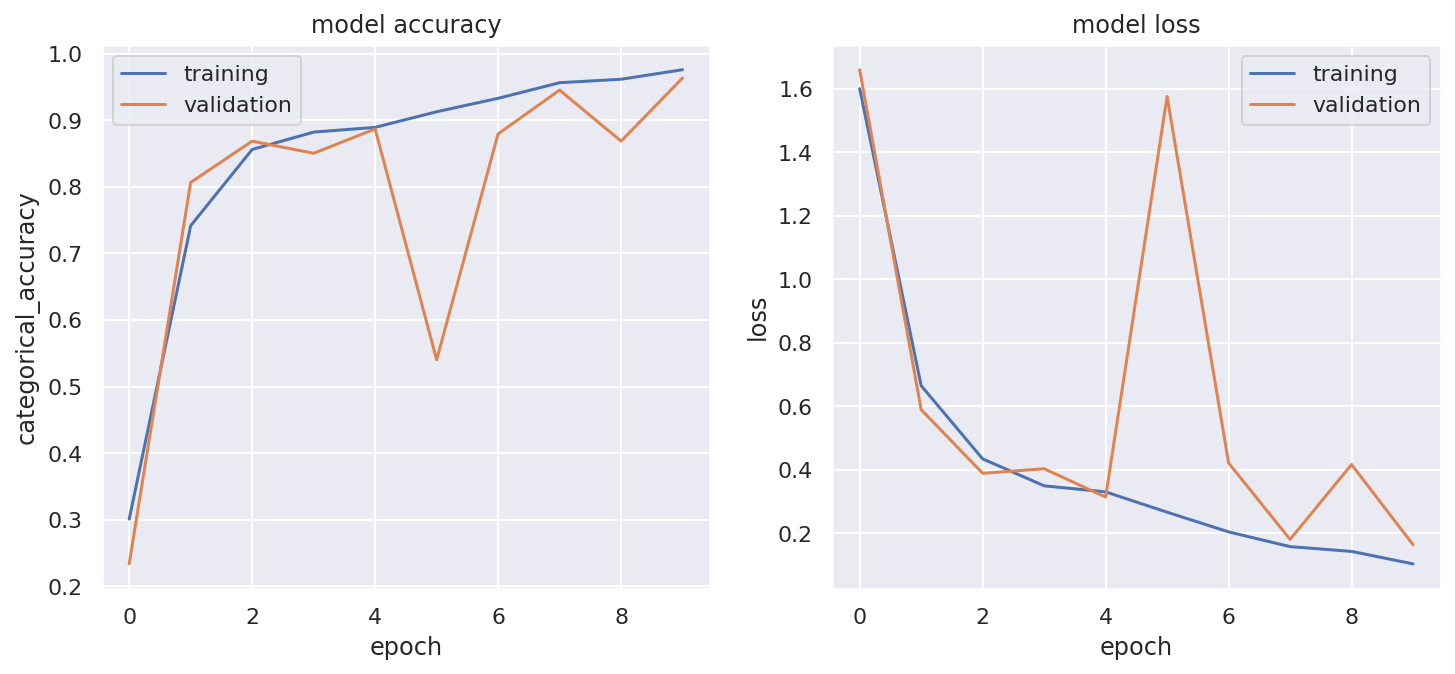

In [11]:
history = history2

# set up figure
f = plt.figure(figsize=(12,5))
f.add_subplot(1,2, 1)

# plot accuracy as a function of epoch
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

# plot loss as a function of epoch
f.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show(block=True)

In [13]:
SUB_PATH = "../input/plant-pathology-2020-fgvc7/sample_submission.csv"

sub = pd.read_csv(SUB_PATH)
predictions = model.predict(test_dataset, verbose=1)
sub.loc[:, 'healthy':] = predictions
sub.to_csv('submission2.csv', index=False)
sub.head()

57/57 [==============================] - 100s 2s/step


,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.000025,0.113659,0.885526,0.000790
1,Test_1,0.001162,0.014953,0.980920,0.002965
2,Test_2,0.000458,0.000240,0.002135,0.997166
3,Test_3,0.998010,0.000454,0.001299,0.000237
4,Test_4,0.000241,0.030790,0.967496,0.001473


___

In [14]:
test = pd.read_csv(path + 'test.csv')
train = pd.read_csv(path + 'train.csv')
train['image_id']=train['image_id']+'.jpg'  # this is used in the image data generator below
test['image_id']=test['image_id']+'.jpg'

In [16]:
train, val = train_test_split(train, test_size = 0.3)

In [17]:
datagen = ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rotation_range=45,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=.1,
                                fill_mode='nearest',
                                shear_range=0.1,
                                rescale=1/255,
                                brightness_range=[0.5, 1.5])

# prepare an iterators to scale images
train_gen = datagen.flow_from_dataframe(train,
                                        directory=path+'images/',
                                        target_size=(image_size, image_size),
                                        x_col="image_id",
                                        y_col=['healthy','multiple_diseases','rust','scab'],
                                        class_mode='raw',
                                        shuffle=False,
                                        subset='training',
                                        batch_size=50)

val_gen = datagen.flow_from_dataframe(val,
                                        directory=path+'images/',
                                        target_size=(image_size,image_size),
                                        x_col="image_id",
                                        y_col=['healthy','multiple_diseases','rust','scab'],
                                        class_mode='raw',
                                        shuffle=False,
                                        batch_size=50)

test_gen = datagen.flow_from_dataframe(test,
                                        directory=path+'images/',
                                        target_size=(image_size,image_size),
                                        x_col="image_id",
                                        y_col=None,
                                        class_mode=None,
                                        shuffle=False,
                                        batch_size=50)

Found 1274 validated image filenames.
Found 547 validated image filenames.
Found 1821 validated image filenames.


In [18]:
from keras import regularizers
from keras.models import Model
from keras.applications import densenet
from keras.layers import Activation, Dropout, Flatten, Dense, LeakyReLU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

# Option 1
with tpu_strategy.scope():
    model = densenet.DenseNet121(input_shape=(image_size, image_size, 3),
                                     weights='imagenet',
                                     include_top=False,
                                     pooling='avg')
    for layer in model.layers:
        layer.trainable = True

    x = model.output
    predictions = Dense(4, activation='softmax')(x)
    model = Model(inputs=model.input, outputs=predictions)
    
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['categorical_accuracy'])

In [19]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
callbacks_list = [early_stop, reduce_lr]

In [20]:
# Option 1
train_step = train_gen.n//train_gen.batch_size
val_step = val_gen.n//val_gen.batch_size
history3 = model.fit_generator(generator=train_gen,
                                steps_per_epoch=train_step,
                                validation_data=val_gen,
                                validation_steps=val_step,
                                epochs=20,
                                callbacks=callbacks_list,
                             )

Epoch 1/20
25/25 [==============================] - 251s 10s/step - loss: 0.6211 - categorical_accuracy: 0.8129 - val_loss: 69.3421 - val_categorical_accuracy: 0.3220
Epoch 2/20
25/25 [==============================] - 222s 9s/step - loss: 0.3255 - categorical_accuracy: 0.9028 - val_loss: 11.5366 - val_categorical_accuracy: 0.3239
Epoch 3/20
25/25 [==============================] - 220s 9s/step - loss: 0.2340 - categorical_accuracy: 0.9273 - val_loss: 2.2149 - val_categorical_accuracy: 0.5573
Epoch 4/20
25/25 [==============================] - 218s 9s/step - loss: 0.2179 - categorical_accuracy: 0.9338 - val_loss: 4.0289 - val_categorical_accuracy: 0.6056
Epoch 5/20
25/25 [==============================] - 217s 9s/step - loss: 0.1979 - categorical_accuracy: 0.9404 - val_loss: 2.3975 - val_categorical_accuracy: 0.7505
Epoch 6/20
25/25 [==============================] - 215s 9s/step - loss: 0.1899 - categorical_accuracy: 0.9412 - val_loss: 0.6858 - val_categorical_accuracy: 0.7344
Epoch 7

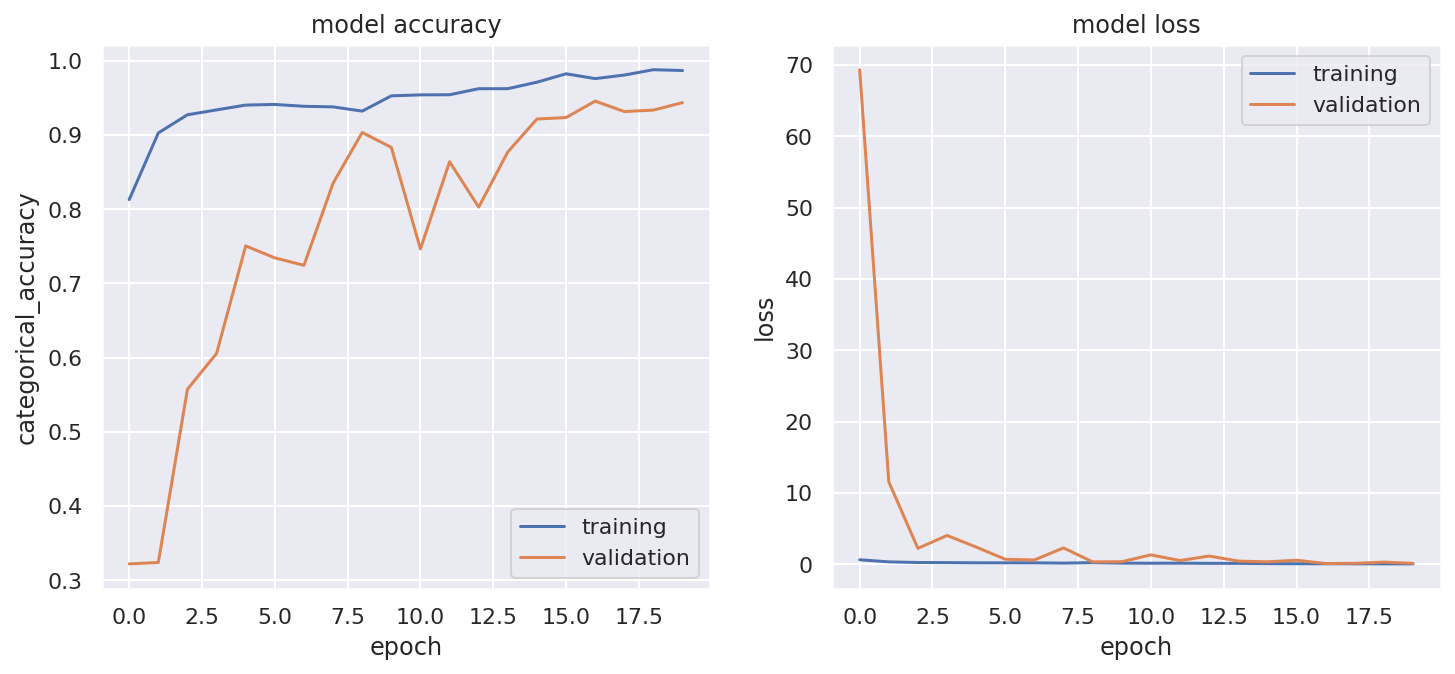

In [21]:
history = history3

# set up figure
f = plt.figure(figsize=(12,5))
f.add_subplot(1,2, 1)

# plot accuracy as a function of epoch
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

# plot loss as a function of epoch
f.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show(block=True)

In [22]:
SUB_PATH = "../input/plant-pathology-2020-fgvc7/sample_submission.csv"

sub = pd.read_csv(SUB_PATH)
predictions = model.predict(test_gen, verbose=1)
sub.loc[:, 'healthy':] = predictions
sub.to_csv('submission3.csv', index=False)
sub.head()

37/37 [==============================] - 125s 3s/step


,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,1.281538e-08,0.003145,9.968553e-01,4.716738e-09
1,Test_1,3.430524e-05,0.054884,9.450679e-01,1.356755e-05
2,Test_2,1.398819e-07,0.000039,1.703341e-08,9.999613e-01
3,Test_3,9.999212e-01,0.000002,3.205980e-05,4.451852e-05
4,Test_4,1.799182e-10,0.000237,9.997634e-01,4.911716e-11
